In [1]:
# Install necessary packages through pip

# %pip install transformers torch
# %pip install transformers --upgrade
# %pip install pandasai
# %pip install dspy
# %pip install dspy-ai

In [1]:
# Importing necessary libraries

import shap
import warnings
import dspy
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")

In [2]:
def analyze_dataframe(df, cardinality_threshold = 20, top_n = 3):

    summary = []
    for col in df.columns:
        data = df[col]
        col_summary = {
            'Column': col,
            'Data Type': data.dtype,
            'Missing Count': data.isnull().sum(),
            'Missing %': round(data.isnull().mean() * 100, 2),
            'Unique Count': data.nunique(),
        }

        if pd.api.types.is_numeric_dtype(data) or pd.api.types.is_string_dtype(data):
            col_summary['Cardinality'] = 'High' if data.nunique() > cardinality_threshold else 'Low'
        else:
            col_summary['Cardinality'] = 'N/A'

        value_counts = data.value_counts(dropna = True).head(top_n)
        col_summary['Top Values'] = value_counts.to_dict()

        if pd.api.types.is_numeric_dtype(data):
            # IQR Method
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            iqr_outliers = data[(data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))]

            # Z-score method
            z_scores = np.abs(stats.zscore(data.dropna()))
            z_outliers = data.dropna()[(z_scores > 3) | (z_scores < -3)]

            # ###########################################
            # 
            # 
            # Outliers are for the target column only
            # 
            # 
            # ###########################################

            col_summary['Outliers (IQR)'] = len(iqr_outliers)
            col_summary['Outliers (Z-score)'] = len(z_outliers)
        else:
            col_summary['Outliers (IQR)'] = 'N/A'
            col_summary['Outliers (Z-score)'] = 'N/A'

        summary.append(col_summary)

    summary_df = pd.DataFrame(summary)
    return summary_df

In [3]:
def analyze_numerical_features(df):
    numeric_df = df.select_dtypes( include = [ np.number ] )
    summary = []

    for col in numeric_df.columns:
        data = numeric_df[col].dropna()
        col_summary = {
            'Column': col,
            'Mean': data.mean(),
            'Median': data.median(),
            'Mode': data.mode().iloc[0] if not data.mode().empty else np.nan,
            'Min': data.min(),
            'Max': data.max(),
            'Range': data.max() - data.min(),
            'Std Dev': data.std(),
            'Variance': data.var(),
            'Skewness': skew(data),
            'Kurtosis': kurtosis(data)
        }

        summary.append(col_summary)

    return pd.DataFrame(summary)

In [4]:
def analyze_categorical_features_by_cardinality(df, top_n = 5, cardinality_threshold = 20):

    summary = []
    for col in df.columns:
        unique_count = df[col].nunique(dropna = True)

        if unique_count <= cardinality_threshold:
            data = df[col].dropna()

            freq_counts = data.value_counts().head(top_n).to_dict()
            mode_val = data.mode().iloc[0] if not data.mode().empty else None

            summary.append({
                'Column': col,
                'Unique Count': unique_count,
                'Top Frequencies': freq_counts,
                'Mode': mode_val
            })

    return pd.DataFrame(summary)

In [5]:
def analyze_feature_target_relationship(df, target_col, cardinality_threshold=20):
    df = df.copy()
    results = []

    df = df.dropna(subset = [target_col])
    is_target_categorical = df[target_col].nunique() <= cardinality_threshold

    if is_target_categorical:
        y = LabelEncoder().fit_transform(df[target_col])
    else:
        y = df[target_col]

    X = df.drop(columns = [target_col])
    X = X.fillna(999999999)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].nunique() <= cardinality_threshold:
            X[col] = X[col].astype(str)
            X[col] = LabelEncoder().fit_transform(X[col])

    numeric_cols = X.select_dtypes(include=[np.number]).columns
    corrs = X[numeric_cols].corrwith(pd.Series(y))
    for col, val in corrs.items():
        if not pd.isnull(val):
            results.append({'Feature': col, 'Metric': 'Correlation Coeff', 'Score': round(float(val), 4)})

    # 2 & 3. Feature Importance via Decision Trees (Entropy & Gini)
    for crit in ['entropy', 'gini']:
        clf = DecisionTreeClassifier(criterion = crit, max_depth = 5, random_state = 0)
        clf.fit(X, y)
        importances = clf.feature_importances_
        for col, score in zip(X.columns, importances):
            results.append({
                'Feature': col,
                'Metric': f'Feature Importance ({crit.capitalize()})',
                'Score': round(float(score), 4)
            })

    # 4. Chi-Squared Score (categorical target only)
    if is_target_categorical:
        chi2_scores, _ = chi2(X, y)
        for col, score in zip(X.columns, chi2_scores):
            results.append({
                'Feature': col,
                'Metric': 'Chi-Squared',
                'Score': round(float(score), 4)
            })

    # 5. Target Value Counts
    print("\nTarget Value Counts:")
    print(df[target_col].value_counts(dropna = False))

    return pd.DataFrame(results).sort_values(['Metric', 'Score'], ascending=[True, False])


In [ ]:

target_file = "Dataset/Lead_Scoring.csv"
df = pd.read_csv(target_file)
pd.set_option("display.max_colwidth", None)

In [7]:
individual_feature_analysis = analyze_dataframe(df)
individual_feature_analysis

,Column,Data Type,Missing Count,Missing %,Unique Count,Cardinality,Top Values,Outliers (IQR),Outliers (Z-score)
0,Prospect ID,object,0,0.00,9240,High,"{'7927b2df-8bba-4d29-b9a2-b6e0beafe620': 1, '22e9d4ef-d294-4ebf-81c7-7c7a1105aeea': 1, '46befc49-253a-419b-abea-2fd978d2e2b1': 1}",N/A,N/A
1,Lead Number,int64,0,0.00,9240,High,"{660737: 1, 603303: 1, 602561: 1}",0,0
2,Lead Origin,object,0,0.00,5,Low,"{'Landing Page Submission': 4886, 'API': 3580, 'Lead Add Form': 718}",N/A,N/A
3,Lead Source,object,36,0.39,21,High,"{'Google': 2868, 'Direct Traffic': 2543, 'Olark Chat': 1755}",N/A,N/A
4,Do Not Email,object,0,0.00,2,Low,"{'No': 8506, 'Yes': 734}",N/A,N/A
5,Do Not Call,object,0,0.00,2,Low,"{'No': 9238, 'Yes': 2}",N/A,N/A
6,Converted,int64,0,0.00,2,Low,"{0: 5679, 1: 3561}",0,0
7,TotalVisits,float64,137,1.48,41,High,"{0.0: 2189, 2.0: 1680, 3.0: 1306}",267,68
8,Total Time Spent on Website,int64,0,0.00,1731,High,"{0: 2193, 60: 19, 74: 18}",0,8
9,Page Views Per Visit,float64,137,1.48,114,High,"{0.0: 2189, 2.0: 1795, 3.0: 1196}",360,120


In [8]:
numerical_feature_analysis = analyze_numerical_features(df)
numerical_feature_analysis

,Column,Mean,Median,Mode,Min,Max,Range,Std Dev,Variance,Skewness,Kurtosis
0,Lead Number,617188.435606,615479.0,579533.0,579533.0,660737.0,81204.0,23405.995698,5.478406e+08,0.140428,-1.206390
1,Converted,0.385390,0.0,0.0,0.0,1.0,1.0,0.486714,2.368901e-01,0.470982,-1.778176
2,TotalVisits,3.445238,3.0,0.0,0.0,251.0,251.0,4.854853,2.356959e+01,19.908376,853.009329
3,Total Time Spent on Website,487.698268,248.0,0.0,0.0,2272.0,2272.0,548.021466,3.003275e+05,0.956295,-0.404201
4,Page Views Per Visit,2.362820,2.0,0.0,0.0,55.0,55.0,2.161418,4.671727e+00,2.871320,42.338424
5,Asymmetrique Activity Score,14.306252,14.0,14.0,7.0,18.0,11.0,1.386694,1.922920e+00,-0.383265,1.230664
6,Asymmetrique Profile Score,16.344883,16.0,15.0,11.0,20.0,9.0,1.811395,3.281152e+00,0.221672,-0.620309


In [9]:
categorical_feature_analysis = analyze_categorical_features_by_cardinality(df, cardinality_threshold = 20)
categorical_feature_analysis

,Column,Unique Count,Top Frequencies,Mode
0,Lead Origin,5,"{'Landing Page Submission': 4886, 'API': 3580, 'Lead Add Form': 718, 'Lead Import': 55, 'Quick Add Form': 1}",Landing Page Submission
1,Do Not Email,2,"{'No': 8506, 'Yes': 734}",No
2,Do Not Call,2,"{'No': 9238, 'Yes': 2}",No
3,Converted,2,"{0: 5679, 1: 3561}",0
4,Last Activity,17,"{'Email Opened': 3437, 'SMS Sent': 2745, 'Olark Chat Conversation': 973, 'Page Visited on Website': 640, 'Converted to Lead': 428}",Email Opened
5,Specialization,19,"{'Select': 1942, 'Finance Management': 976, 'Human Resource Management': 848, 'Marketing Management': 838, 'Operations Management': 503}",Select
6,How did you hear about X Education,10,"{'Select': 5043, 'Online Search': 808, 'Word Of Mouth': 348, 'Student of SomeSchool': 310, 'Other': 186}",Select
7,What is your current occupation,6,"{'Unemployed': 5600, 'Working Professional': 706, 'Student': 210, 'Other': 16, 'Housewife': 10}",Unemployed
8,What matters most to you in choosing a course,3,"{'Better Career Prospects': 6528, 'Flexibility & Convenience': 2, 'Other': 1}",Better Career Prospects
9,Search,2,"{'No': 9226, 'Yes': 14}",No


In [10]:
feature_target_relationship_analysis = analyze_feature_target_relationship(df, target_col = 'Converted')
feature_target_relationship_analysis


Target Value Counts:
0    5679
1    3561
Name: Converted, dtype: int64


,Feature,Metric,Score
111,Page Views Per Visit,Chi-Squared,6.865835e+10
109,TotalVisits,Chi-Squared,6.865834e+10
110,Total Time Spent on Website,Chi-Squared,7.475562e+05
126,Tags,Chi-Squared,8.053446e+03
104,Lead Number,Chi-Squared,5.190025e+03
...,...,...,...
96,Asymmetrique Activity Index,Feature Importance (Gini),0.000000e+00
97,Asymmetrique Profile Index,Feature Importance (Gini),0.000000e+00
99,Asymmetrique Profile Score,Feature Importance (Gini),0.000000e+00
100,I agree to pay the amount through cheque,Feature Importance (Gini),0.000000e+00


In [11]:
# Shap values

target_col = 'Converted'
redundant_columns = ["Prospect ID", "Lead Number"]
redundant_columns.append(target_col)

X = df.drop(columns = redundant_columns, errors = 'ignore')
y = df[target_col]
label_encoders = dict()

for col in X.columns:
    if not pd.api.types.is_numeric_dtype(col):
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

original_converted_columns = dict()

for col in label_encoders:
    original_converted_columns[col] = label_encoders[col].inverse_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
model = RandomForestClassifier(n_estimators = 100, random_state = 42)
model.fit(X_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


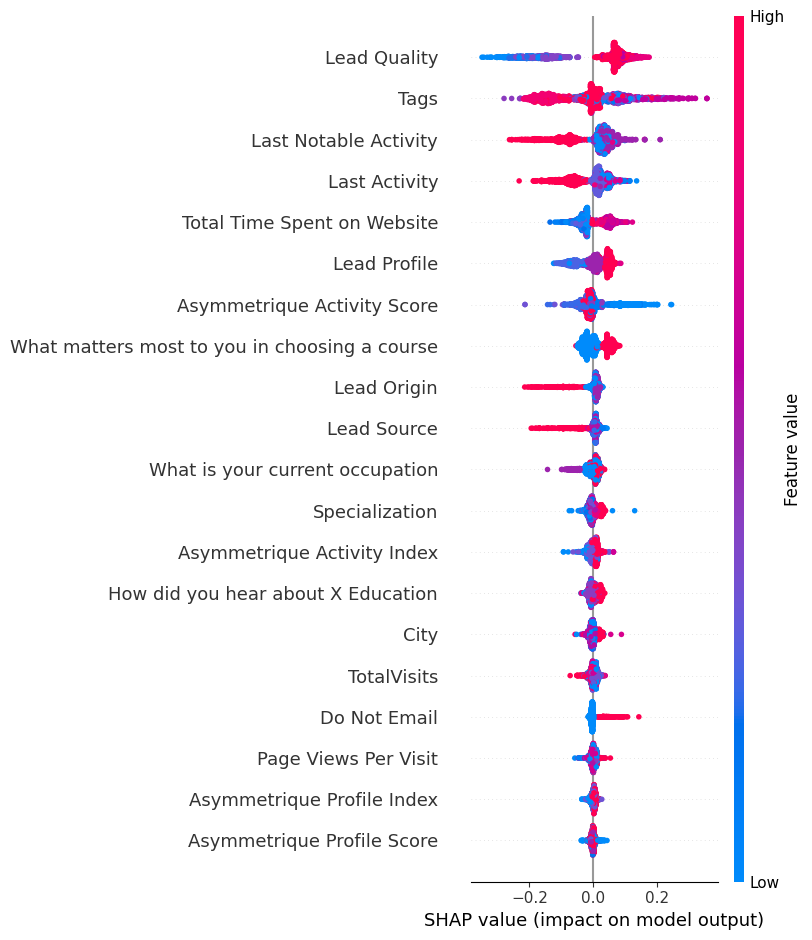

In [12]:
shap_class_0 = shap_values[:, :, 0]
shap.summary_plot(shap_class_0, X_test)

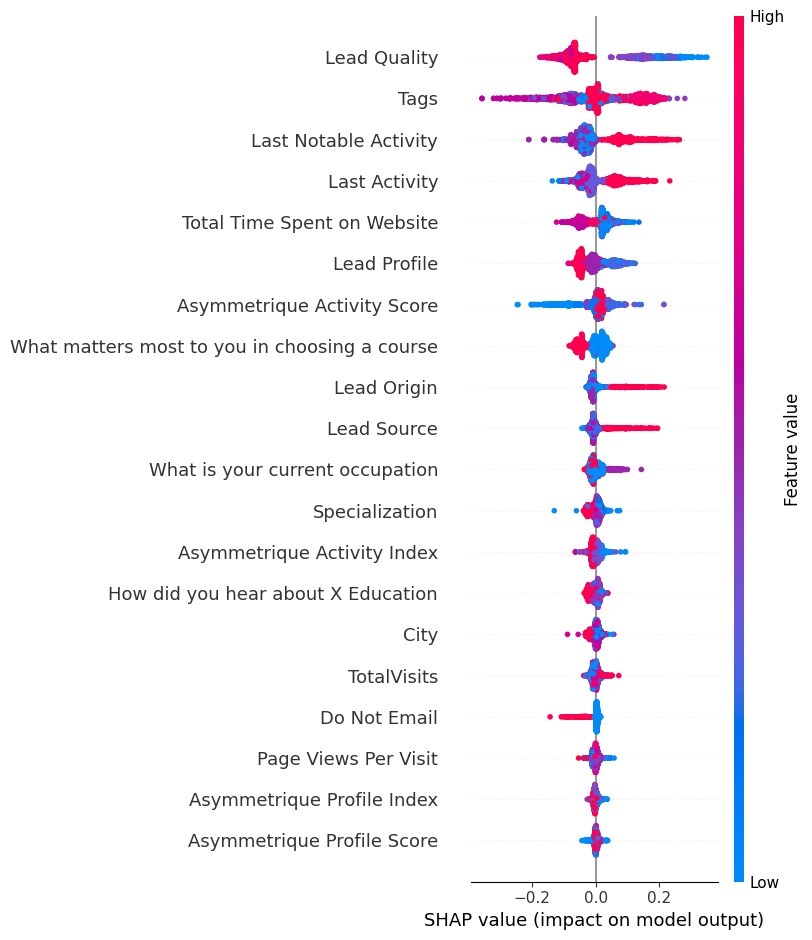

In [13]:
# print(shap_values.shape)
# X_test.shape

shap_class_1 = shap_values[:, :, 1]
shap.summary_plot(shap_class_1, X_test)

In [15]:
# # Attempt 1

lm = dspy.LM(
    model = "mistral",
    api_base = "http://localhost:11434",
    model_type = "completion"
)

dspy.configure(lm = lm)

In [17]:
# Attempt 2

lm = dspy.LM(
    model = "mistral",
    api_base = "http://localhost:11434",
    api_key = "",
    model_type = "completion"
)
dspy.configure(lm = lm)

In [ ]:
# Attempt 2

output = analyze_feature_target_relationship(df, target_col = 'Converted')
df_text = feature_target_relationship_analysis.to_string(index = False)

df_correlation = feature_target_relationship_analysis.to_string(index = False)
df_individual = individual_feature_analysis
df_numerical = numerical_feature_analysis
df_categorical = categorical_feature_analysis


prompt = f"""
Below is a table showing feature importance using the Chi-Squared statistical test, values of correlation with the target variable and the mentioned feature and feature importance (entropy and gini).

{df_correlation}

Each row shows:
- a feature from the dataset
- the statistical test used
- the computed score (higher = more influence on the target variable)

For the below three analysis, the first column contains the feature names while the other columns showcase the statistical parameter measured

Individual feature analysis:
{df_individual}

Numerical feature analysis:
{df_numerical}

Categorical feature analysis
{df_categorical}

Explain this in simple language. Highlight which features are most important and which seem to have little influence. Avoid technical jargon.

"""

response = requests.post(
    "http://localhost:11434/api/generate",
    json={
        "model": "mistral",
        "prompt": prompt,
        "stream": False
    }
)



Target Value Counts:
0    5679
1    3561
Name: Converted, dtype: int64


In [21]:
if response.ok:
    result = response.json()
    print("\nInsight:\n")
    print(result["response"].strip())
else:
    print("Ollama API error:", response.status_code, response.text)


Insight:

This analysis provides a summary of the data collected for potential students interacting with an education platform. Here's a simplified explanation:

1. **Lead Origin** (0-5 unique counts): This category shows where leads are coming from, such as Landing Page Submission or API. The most common source is the Landing Page Submission.

2. **Do Not Email/Call** (No=8506, Yes=734): A majority of leads do not want to be emailed or called. This could suggest that the platform should focus on other means of communication.

3. **Converted** (No=9238, Yes=2): Few leads have been converted from potential students to actual students. This might indicate a need for improvement in conversion strategies.

4. **How did you hear about X Education** (10 unique counts): This category indicates how leads found out about the education platform. The most common methods are Online Search and Word of Mouth.

5. **Lead Quality**: This seems to have little influence, as most leads fall under the 'N